# smrt run

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../smrt/smrt-master/smrt')

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09

In [2]:
def profile(snowt,icet,Ts,icetype):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['fy'/'my']
    
    snow_grain_size = 20
    
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness
    di=0.01*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0
    else:
        snow_density[0:w]=250.0
        snow_density[w:]=330.0
        snow_density=np.flipud(snow_density)
        
    #First-year ice density (icethickness)
    if icetype=='fy': 
        ice_density=np.zeros(hi)
        ice_density[:]=926.0
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='my':
        ice_density=np.zeros(hi)
        humdens=np.zeros(20)
        tdens=750.0
        bdens=910.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='fy': ice_pcc[:]=0.1
    elif icetype=='my': 
        ice_pcc[0:20]=1.5
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='fy':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='my':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='fy': ice_type[:]=3
    elif icetype=='my': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

In [3]:
def smrt_profile(snowt,icet,Ts,icetype):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']
    
        
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness
    di=0.01*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0
    else:
        snow_density[0:w]=250.0
        snow_density[w:]=330.0
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=926.0
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        humdens=np.zeros(20)
        tdens=750.0
        bdens=910.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 20
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

In [4]:
#from smrt.inputs.make_medium import make_ice_column
ice_type = 'multiyear' # firstyear or multiyear sea ice
#smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
[num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(0.15,2.15,250,ice_type)
#split into snow and sea ice indices
snow=(si==0)
ice=(si==1)
#the profiles: snow
thickness_snow=di[snow]
density_snow=roi[snow]
temperature_snow=Ti[snow]
p_ex_snow=pci[snow]*1e-3
salinity_snow=sal[snow]*PSU

#profiles: ice
thickness_ice=di[ice]
temperature_ice=Ti[ice]
salinity_ice=sal[ice]*PSU
density_ice=roi[ice]
p_ex_ice=pci[ice]*1e-3


ice_column = make_ice_column(ice_type=ice_type,
                            thickness=thickness_ice,
                            temperature=temperature_ice,
                            microstructure_model="exponential",
                            brine_inclusion_shape="spheres", 
                            salinity=salinity_ice, 
                            density = density_ice,
                            corr_length=p_ex_ice,
                            add_water_substrate="ocean"
                            )
snowpack = make_snowpack(thickness=thickness_snow,
                         microstructure_model="exponential",
                         density=density_snow,
                         temperature=temperature_snow,
                         corr_length=p_ex_snow,
                         salinity=salinity_snow,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)


#add snowpack on top of ice column:
medium = snowpack + ice_column

# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"
m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})

# run the model for snow-covered sea ice:
brightness_temperatures = m.run(sensor, medium)



SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>


C:\Users\fnifd\anaconda3\envs\Bachelor\lib\site-packages\smrt\permittivity\saline_snow.py:29: UserWarning: The permittivity model of Geldsetzer et al. 2009 (doi:10.1016/j.coldregions.2009.03.009) was developed for the frequency range 10 MHz - 40 GHz.
  warnings.warn(


SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001565A25CA00>


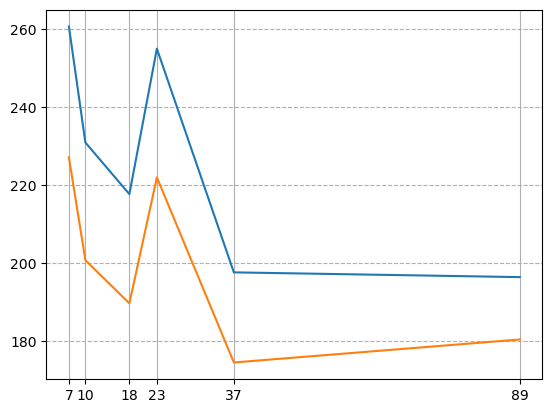

In [42]:
# print TBs at horizontal and vertical polarization Tb's:
#print(brightness_temperatures.TbH(), brightness_temperatures.TbV())

freqs=np.array([7,10,18,23,37,89])
plt.plot(freqs,brightness_temperatures.TbV())
plt.plot(freqs,brightness_temperatures.TbH())
plt.xticks(freqs)
plt.grid(axis='x')
plt.grid(axis='y',linestyle='--')
plt.show()